In [1]:
import tensorflow as tf
import numpy as np
import sys

from sklearn.metrics import mean_squared_error
from keras.callbacks import LearningRateScheduler
#from sklearn.preprocessing import MinMaxScaler ##########

sys.path.append('/Users/davidlaredorazo/Documents/University_of_California/Research/Projects')
#sys.path.append('/Users/Think/Desktop/project')

#Tunable model
from ann_framework.tunable_model.tunable_model import SequenceTunableModelRegression

#Data handlers
from ann_framework.data_handlers.data_handler_Oscillator import OscillatorDataHandler

#Custom modules
from ann_framework import aux_functions

import aux_functions_stochastic
import analytic_functions
import loss_functions


Using TensorFlow backend.


In [2]:
#global variables

deltas = [0.01, 0.01]

k = 1
c = 0.1
D = 1
num_fevals = 5

### Define tensorflow model

In [3]:
def create_placeholders(input_shape, output_shape):
    
    X = tf.placeholder(tf.float32, shape=(None,input_shape), name="X")
    y = tf.placeholder(tf.float32, shape=None, name="y")
    
    return X, y

"""
def tf_model(X):
    
    l2_lambda_regularization = 0.20
    l1_lambda_regularization = 0.10
    
    A1 = tf.layers.dense(X, 20, activation=tf.nn.relu, 
                         kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False), 
                         kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(l1_lambda_regularization,l2_lambda_regularization), 
                         name="fc1")
    A2 = tf.layers.dense(A1, 20, activation=tf.nn.relu, 
                         kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False),
                         kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(l1_lambda_regularization,l2_lambda_regularization), name="fc2")
    y = tf.layers.dense(A2, 1, activation=None, kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False),
                        kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(l1_lambda_regularization,l2_lambda_regularization), name="out")
    
    return y
"""

def tf_model_yulin(X):
    
    A1 = tf.layers.dense(X, 32, activation=tf.nn.tanh, 
                         kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False),name="fc1")
    """
    dropout1 = tf.layers.dropout(inputs = A1, rate = 0.2)
    A2 = tf.layers.dense(A1, 20, activation=tf.nn.elu, 
                         kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False),
                         kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(l1_lambda_regularization,l2_lambda_regularization), name="fc2")
    dropout2 = tf.layers.dropout(inputs = A2, rate = 0.2)
    A3 = tf.layers.dense(A2, 20, activation=tf.nn.elu, 
                         kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False),
                         kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(l1_lambda_regularization,l2_lambda_regularization), name="fc3")
    dropout3 = tf.layers.dropout(inputs = A3, rate = 0.2)
    A4 = tf.layers.dense(A3, 20, activation=tf.nn.elu, 
                         kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False),
                         kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(l1_lambda_regularization,l2_lambda_regularization), name="fc4")
    dropout4 = tf.layers.dropout(inputs = A4, rate = 0.2)
    """
    y = tf.layers.dense(A1, 1, activation=None, kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False),
                        name="out")
    #activation funcs
    
    return y


### Create Model TF

In [4]:
def tf_compiled_model(num_features, output_shape):
    tf.reset_default_graph()

    X, y = create_placeholders(num_features, output_shape)

    #y_pred = tf_model(X)
    y_pred = tf_model_yulin(X)
    
    loss_function = loss_functions.squared_residual_function_wrapper2(k, c, D, deltas, num_fevals)
    cost, e = loss_function(X, y_pred, y)
    #reg_cost = tf.losses.get_regularization_loss()
    total_cost = e
    
    optimizer = tf.train.AdamOptimizer(learning_rate=0.01, beta1=0.5).minimize(total_cost)

    return {'X_placeholder': X, 'y_placeholder': y, 'y_pred': y_pred, 'cost': cost, 'total_cost': total_cost, 'optimizer': optimizer}

### Create Tunable Model Tensorflow and assign data

In [5]:
#scaler = MinMaxScaler()

dhandler_stochastic = OscillatorDataHandler()

#(data_scaler = scaler)

model = tf_compiled_model(2, 1)

tModel = SequenceTunableModelRegression('ModelStochastic_SN_1', model, lib_type='tensorflow', 
                                        data_handler=dhandler_stochastic)

tModel.load_data(verbose=1, cross_validation_ratio=0.2, x=[0, 0], boundaries=[10, 10], n=[50, 50])

#Real phi function
sigma_x = np.sqrt(D / (k * c))
sigma_y = np.sqrt(D / c)
p_real_test, phi_real_test = analytic_functions.real_p(tModel.X_test[:,0], tModel.X_test[:,1], sigma_x, sigma_y)
p_real_train, phi_real_train = analytic_functions.real_p(tModel.X_train[:,0], tModel.X_train[:,1], sigma_x, sigma_y)
p_real_crossVal, phi_real_crossVal = analytic_functions.real_p(tModel.X_crossVal[:,0], tModel.X_crossVal[:,1], sigma_x, sigma_y)

tModel.y_test = phi_real_test
tModel.y_train = phi_real_train
tModel.y_crossVal = phi_real_crossVal


tModel.print_data()

Loading data. Cros-Validation ratio 0.2
Printing shapes

Training data (X, y)
(7200, 2)
(7200, 1)
Cross-Validation data (X, y)
(1800, 2)
(1800, 1)
Testing data (X, y)
(1000, 2)
(1000, 1)
Printing first 5 elements

Training data (X, y)
[[-8.18181818 -1.91919192]
 [ 3.13131313  6.56565657]
 [ 6.16161616 -7.17171717]
 [ 1.31313131 -9.39393939]
 [ 6.36363636  2.92929293]]
[[3.53127232]
 [2.6456484 ]
 [4.46995205]
 [4.49852056]
 [2.45383124]]
Cross-Validation data (X, y)
[[ 3.13131313 -0.90909091]
 [ 9.19191919 -3.33333333]
 [ 9.39393939  5.55555556]
 [ 1.11111111  2.52525253]
 [-8.18181818 -7.57575758]]
[[0.53157841]
 [4.78012448]
 [5.95551474]
 [0.38057341]
 [6.21671258]]
Testing data (X, y)
[[ 3.53535354 -4.14141414]
 [-7.97979798 -7.97979798]
 [-1.51515152  1.31313131]
 [ 0.1010101  -1.31313131]
 [-0.90909091  9.7979798 ]]
[[1.48250179]
 [6.36771758]
 [0.2009999 ]
 [0.08672584]
 [4.84134272]]


/Users/davidlaredorazo/anaconda/envs/tensorflow/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Train model Tensorflow

In [6]:
tModel.epochs = 60
#lrate = LearningRateScheduler(aux_functions.step_decay)
minibatches_function_handle = aux_functions_stochastic.get_minibatches

#tf.get_variable("deltas", initializer=deltas)

sess = tf.Session()

#writer = tf.summary.FileWriter('./graphs', sess.graph)

tModel.train_model(tf_session=sess, get_minibatches_function_handle=minibatches_function_handle, 
                   verbose=1, deltas=deltas)

Epoch: 0001 cost_reg= 7.086446317 cost= 139.849018606
Epoch: 0002 cost_reg= 3.843704367 cost= 117.100940450
Epoch: 0003 cost_reg= 2.594381221 cost= 107.148093224
Epoch: 0004 cost_reg= 2.404904779 cost= 75.073587259
Epoch: 0005 cost_reg= 2.393537331 cost= 66.894181188
Epoch: 0006 cost_reg= 2.239214786 cost= 67.530393028
Epoch: 0007 cost_reg= 2.021591783 cost= 76.825582949
Epoch: 0008 cost_reg= 1.756434043 cost= 134.081161054
Epoch: 0009 cost_reg= 1.544855436 cost= 263.324760691
Epoch: 0010 cost_reg= 1.183866429 cost= 478.910976664
Epoch: 0011 cost_reg= 0.903581615 cost= 762.801219432
Epoch: 0012 cost_reg= 0.672785791 cost= 1097.658517456
Epoch: 0013 cost_reg= 0.510111310 cost= 1478.143689982
Epoch: 0014 cost_reg= 0.380004640 cost= 1843.010765584
Epoch: 0015 cost_reg= 0.287903594 cost= 2175.214174398
Epoch: 0016 cost_reg= 0.218457742 cost= 2446.157818604
Epoch: 0017 cost_reg= 0.185896991 cost= 2663.361697388
Epoch: 0018 cost_reg= 0.154595278 cost= 2849.604076131
Epoch: 0019 cost_reg= 0.1

In [7]:
display_points = 50

"""
#Evaluate real model
X_test = tModel.X_crossVal

#Real phi function
sigma_x = np.sqrt(D / (k * c))
sigma_y = np.sqrt(D / c)
p_real, phi_real = analytic_functions.real_p(X_test[:,0], X_test[:,1], sigma_x, sigma_y)

tModel.y_crossVal = phi_real

#p_real = np.ravel(p_real)
#phi_real = np.ravel(phi_real)

tModel.evaluate_model(['mse', 'rmse'], cross_validation=True, tf_session=sess)
#phi_pred = np.ravel(tModel.y_predicted)
phi_pred = tModel.y_predicted

d = 2 * np.pi * sigma_x * sigma_y
c_not = 1/d
p_pred = c_not * np.exp(-phi_pred)
"""

tModel.evaluate_model(['mse', 'rmse'], cross_validation=True, tf_session=sess)
X_test = tModel.X_crossVal
phi_pred = tModel.y_predicted
phi_real = tModel.y_crossVal
print("scores")

cScores = tModel.scores
#rmse = math.sqrt(cScores['score_1'])
rmse2 = cScores['rmse']
mse = cScores['mse']
time = tModel.train_time

total_points = len(phi_pred)
sample_array = list(range(total_points))

sample_points = np.random.choice(sample_array, display_points)

phi_real_sampled = phi_real[sample_points]
phi_pred_sampled = phi_pred[sample_points]
X_sampled = X_test[sample_points,:]

i = range(len(phi_pred_sampled))


for i, phi_real_display, phi_pred_display in zip(i, phi_real, phi_pred):
    print('xy {}, Real Phi {}, Predicted Phi {}'.format(X_test[i], phi_real_display, phi_pred_display))

#print("RMSE: {}".format(rmse))
print("RMSE2: {}".format(rmse2))
print("MSE: {}".format(mse))
print("Time : {} seconds".format(time))

scores
xy [ 3.13131313 -0.90909091], Real Phi [0.53157841], Predicted Phi [0.619228]
xy [ 9.19191919 -3.33333333], Real Phi [4.78012448], Predicted Phi [4.88815]
xy [9.39393939 5.55555556], Real Phi [5.95551474], Predicted Phi [6.0746293]
xy [1.11111111 2.52525253], Real Phi [0.38057341], Predicted Phi [0.47355375]
xy [-8.18181818 -7.57575758], Real Phi [6.21671258], Predicted Phi [6.5131774]
xy [10.         -4.74747475], Real Phi [6.12692582], Predicted Phi [5.8778696]
xy [-0.50505051 -3.73737374], Real Phi [0.71115192], Predicted Phi [0.7712165]
xy [6.36363636 9.19191919], Real Phi [6.24936231], Predicted Phi [6.452705]
xy [7.57575758 6.36363636], Real Phi [4.89439853], Predicted Phi [5.26281]
xy [ 0.1010101  -3.53535354], Real Phi [0.62544638], Predicted Phi [0.70310247]
xy [ 6.16161616 -4.34343434], Real Phi [2.84154678], Predicted Phi [2.910212]
xy [5.15151515 1.31313131], Real Phi [1.41312111], Predicted Phi [1.5078729]
xy [ 7.37373737 -7.97979798], Real Phi [5.90245893], Predict

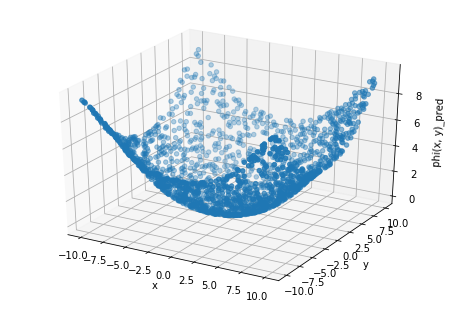

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig1 = plt.figure(1)
ax1 = Axes3D(fig1)
pred_phi_plot = Axes3D.scatter(ax1, tModel.X_crossVal[:,0], tModel.X_crossVal[:,1], phi_pred)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('phi(x, y)_pred')

plt.show()

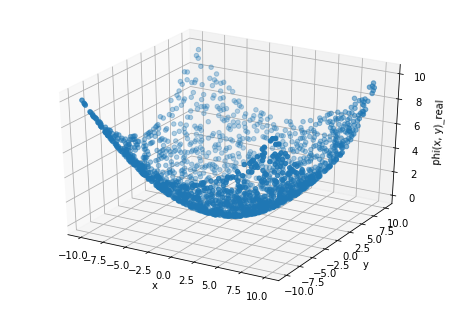

In [9]:
fig2 = plt.figure(2)
ax2 = Axes3D(fig2)
real_phi_plot = Axes3D.scatter(ax2, tModel.X_crossVal[:,0], tModel.X_crossVal[:,1], phi_real)
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_zlabel('phi(x, y)_real')

plt.show()

In [10]:
fig3 = plt.figure(3)
ax3 = Axes3D(fig3)
pred_p_plot = Axes3D.scatter(ax3, tModel.X_crossVal[:,0], tModel.X_crossVal[:,1], p_pred)
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_zlabel('p(x, y)_pred')

plt.show()

NameError: name 'p_pred' is not defined

In [ ]:
fig4 = plt.figure(4)
ax4 = Axes3D(fig4)
real_p_plot = Axes3D.scatter(ax4, tModel.X_crossVal[:,0], tModel.X_crossVal[:,1], p_real)
ax4.set_xlabel('x')
ax4.set_ylabel('y')
ax4.set_zlabel('p(x, y)_real')

plt.show()